In [17]:
import time
#import pydoocs
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import cv2
#import seaborn as sns

In [100]:
f=h5py.File('02272024152848.hdf5', 'r')

In [9]:
f_bg=h5py.File('02272024124128.hdf5', 'r')

In [10]:
image=f['camera_image/cam_img']
imag_bg=f_bg['camera_image/cam_img']

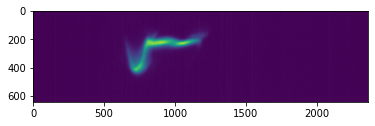

In [11]:
plt.imshow(image[:,:,3])

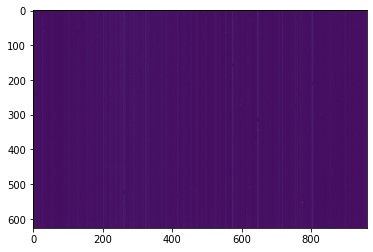

In [55]:
img_bg=np.mean(imag_bg,2)
plt.imshow(img_bg)

In [57]:
bg_img=np.zeros(image[:,:,3].shape)

(626, 960)
(640, 2360)


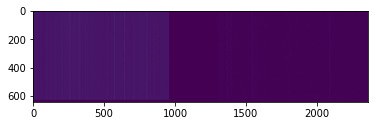

In [65]:
print(img_bg.shape)
print(bg_img.shape)

for i in range(0,625):
    for j in range(0,959):
        bg_img[i,j]=img_bg[i,j]

for i in range(0,625): 
    for j in range(1300, 2359):
        bg_img[i,j]=image[i,j,3]
plt.imshow(bg_img)


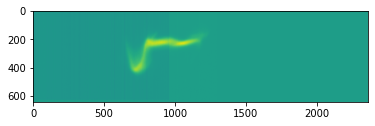

In [67]:
plt.imshow(image[:,:,3]- bg_img)

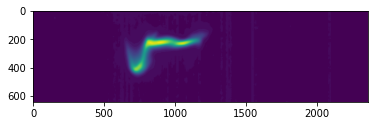

In [52]:
img=np.uint8(image[:,:,3])
image2 =cv2.fastNlMeansDenoising(img,None,200,200)
plt.imshow(image2)

In [69]:
#x_projection=np.mean(image[:,:,3]- bg_img,0)
#plt.plot(x_projection)
####So bad, forget 

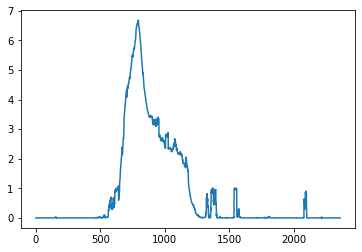

In [53]:

x_projection=np.mean(image2,0)
plt.plot(x_projection)

In [76]:
import numpy as np
from scipy.ndimage import convolve

def hlc_clean_image(input_img):
    input_img = hlc_denoise_image(input_img)

    gaussian_filter = calc_gaussian_2d(35, 7)
    img_filtered = convolve(input_img, gaussian_filter, mode='constant')

    good_soglia = ricerca_soglia_lg(img_filtered, 0.1, 0.03, 35)

    _, maschera = mask_image(img_filtered, good_soglia)
    fondo_punto = np.min(input_img)
    input_img = input_img - fondo_punto

    clean_img = input_img * maschera
    return clean_img

def calc_gaussian_2d(pixels, sigma):
    gauss1d = hlc_calc_gaussian(np.arange(pixels), [0, 1, (pixels-1)/2, sigma])
    matrix = np.outer(gauss1d, gauss1d)
    return matrix

def ricerca_soglia_lg(img_input, guess, tol, n_iter):
    area_s = img_input.size
    signal_s = np.sum(img_input)

    for _ in range(n_iter):
        img_k, mask_k = mask_image(img_input, guess)

        area_k = np.sum(mask_k)
        signal_k = np.sum(img_k)

        noise_k = (signal_s - signal_k) / (area_s - area_k + 1)
        signal_d = signal_k / (area_k + 1)
        s_n_ratio = np.abs(signal_d - noise_k) / (noise_k + 1)
        new_guess = (1 + 1/s_n_ratio) / s_n_ratio / np.sqrt(2)

        if np.abs(new_guess - guess) < tol * guess:
            threshold = min([new_guess, 0.3])
            return threshold
        else:
            guess = new_guess

    return guess

def mask_image(img_in, fraction_of_maximum):
    max_intensity = np.max(img_in)
    mask = (img_in >= max_intensity * fraction_of_maximum)
    masked_image = img_in * mask
    return masked_image, mask

def hlc_denoise_image(img, threshold_factor=3):
    filter_matrix = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]]) / 8
    img_avg = convolve(img.astype(float), filter_matrix, mode='constant')

    mask = (img > threshold_factor * img_avg)

    img_denoised = img.copy()
    img_denoised[mask] = img_avg[mask]
    
    return img_denoised
def hlc_fit_gaussian(x, y):
    fit_data = []
    if not x or not y:
        return fit_data

    x = np.array(x).flatten()
    y = np.array(y).flatten()

    fit_data_pos, sumsq_error_pos = fit_positive_gaussian(x, y)
    fit_data_neg, sumsq_error_neg = fit_positive_gaussian(x, -y)

    if sumsq_error_neg < sumsq_error_pos:
        fit_data = fit_data_neg * np.array([-1, -1, 1, 1])
    else:
        fit_data = fit_data_pos

    fit_data = fmin(err_gaussian, fit_data, disp=False, maxiter=1500, maxfun=1500, args=(x, y))
    return fit_data

def fit_positive_gaussian(x, y):
    baseline = np.min(y)
    height = np.max(y) - baseline
    pb = y - baseline
    pbx = pb * x
    pbxsq = pbx * x
    sum_pb = np.sum(pb)
    if sum_pb == 0:
        sum_pb = 1e-3
    mu = np.sum(pbx) / sum_pb
    sigma = np.sqrt(np.sum(pbxsq) / sum_pb - mu**2)

    initial_params = [baseline, height, mu, sigma]
    fit_data, sumsq_error = fmin(err_gaussian, initial_params, disp=False, maxiter=1500, maxfun=1500, args=(x, y))
    return fit_data, sumsq_error

def err_gaussian(parameters, *data):
    x, y = data
    err = (y - hlc_calc_gaussian(x, parameters))**2
    return np.sum(err)

def hlc_calc_gaussian(x, parameters):
    offset, amplitude, mu, sigma = parameters
    return offset + amplitude * np.exp(-(x - mu)**2 / (2 * sigma**2))



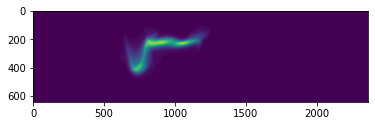

In [77]:
clean_image=hlc_clean_image(image[:,:,3])
plt.imshow(clean_image)

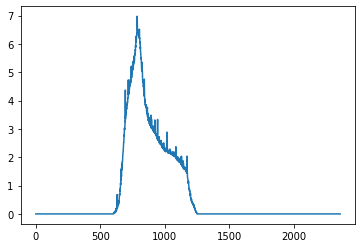

In [78]:
x_projection=np.mean(clean_image,0)
plt.plot(x_projection)

In [79]:
x_pos_good = np.where(x_projection[:] > 0)[0]
x_pos_good = np.arange(min(x_pos_good), max(x_pos_good) + 1)

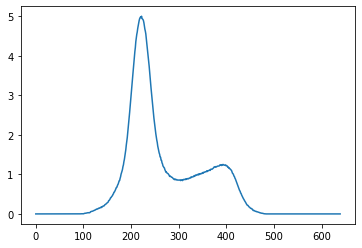

In [81]:
y_projection=np.mean(clean_image,1)
y_pos_good = np.where(y_projection[:] > 0)[0]
y_pos_good = np.arange(min(y_pos_good), max(y_pos_good) + 1)
plt.plot(y_projection)

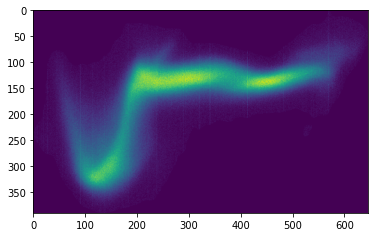

In [87]:
plt.imshow(clean_image[min(y_pos_good):max(y_pos_good),min(x_pos_good):max(x_pos_good)])

In [88]:
immm=clean_image[min(y_pos_good):max(y_pos_good),min(x_pos_good):max(x_pos_good)]

In [162]:
f.close

<bound method File.close of <HDF5 file "02272024152848.hdf5" (mode r)>>

In [164]:
f=h5py.File('02272024152848.hdf5', 'r')


In [182]:
image=f['camera_image/cam_img']
image_data_list = []
for i in range(10):
    clean_image=hlc_clean_image(image[:,:,i])
    x_projection=np.mean(clean_image,0)
    y_projection=np.mean(clean_image,1)
    x_pos_good = np.where(x_projection[:] > 0)[0]
    x_pos_good = np.arange(min(x_pos_good), max(x_pos_good) + 1)
    y_pos_good = np.where(y_projection[:] > 0)[0]
    y_pos_good = np.arange(min(y_pos_good), max(y_pos_good) + 1)

    
    
    cam_img=clean_image[min(y_pos_good):max(y_pos_good),min(x_pos_good):max(x_pos_good)]

    image_data_list.append({'nshot': i+1, 'data': cam_img})

image_data_array = np.array(image_data_list)

In [183]:
image_data_array

array([{'nshot': 1, 'data': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])},
       {'nshot': 2, 'data': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])},
       {'nshot': 3, 'data': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])},
       {'nshot': 4, 'data': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 

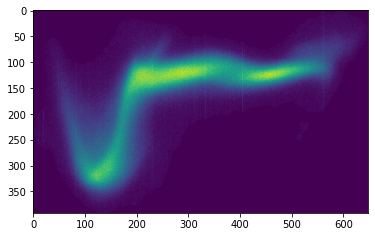

In [187]:
plt.imshow(image_data_array[0]['data'])